In [ ]:
# Análisis Exploratorio de Datos (EDA): Ventas de Videojuegos (VGChartz 2024)

Este análisis exploratorio utiliza un dataset proporcionado por VGChartz que recopila información de más de 64.000 videojuegos publicados en distintas plataformas. El objetivo principal es:

- Comprender la estructura del dataset.
- Evaluar la calidad de la información (valores nulos, duplicados e incoherencias).
- Realizar un proceso de limpieza de datos.
- Generar visualizaciones básicas que ayuden a interpretar patrones de ventas, géneros, plataformas y puntuaciones.
- Dejar el dataset preparado para futuros análisis más avanzados.

Las columnas provienen del diccionario `vg_data_dictionary.csv`, que describe cada variable. 
Estas son las columnas descritas en el diccionario:

img - URL slug for the box art at vgchartz.com
title - Game title
console - Console the game was released for
genre - Genre of the game
publisher - Publisher of the game
developer - Developer of the game
critic_score - Metacritic score (out of 10)
total_sales - Global sales of copies in millions
na_sales - North American sales of copies in millions
jp_sales - Japanese sales of copies in millions
pal_sales - European & African sales of copies in millions
other_sales - Rest of world sales of copies in millions
release_date - Date the game was released on
last_update - Date the data was last updated



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones de visualización
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# Cargar dataset
df = pd.read_csv("../data/dataset.csv")

df.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [ ]:
## 1.1 Exploración del dataset

En esta sección se analiza la estructura del dataset y su calidad general utilizando distintas inspecciones básicas. Para ello se responden las preguntas propuestas en el ejercicio.

### **1. Dimensiones, columnas y tipos de datos**
El dataset contiene información sobre videojuegos, incluyendo título, consola, género, desarrollador, fecha de lanzamiento y ventas regionales.  

A nivel estructural:
- Se revisa el número total de filas (registros) y columnas.
- Se inspeccionan las primeras filas para comprender la forma general del dataset.
- Se examinan los tipos de datos que maneja cada columna (numéricos, categóricos, fechas, texto libre, etc.).

### **2. Tipos de datos presentes**
En este dataset encontramos:
- **Numéricos**: ventas regionales, ventas globales, puntuación crítica.
- **Categóricos**: género, consola, publisher (distribuidora) , developer.
- **Fechas**: release_date y last_update (inicialmente en formato texto).
- **Texto libre**: título del juego, URL de imagen.

### **3. Dominio del dataset**
El dataset pertenece al dominio del mercado del videojuego. Sus variables describen:
- Características de cada videojuego.
- Metadatos de publicación.
- Ventas en distintas regiones del mundo.
- Puntuaciones de crítica.

El diccionario de datos confirma que la fuente agrupa información de múltiples plataformas históricas (PS2, PS3, Xbox, Nintendo, Steam, etc.). Por lo tanto, el contexto es coherente con la temática.

### **4. Fiabilidad y completitud de la fuente**
La fuente (`VGChartz`) es conocida, pero no es una base oficial del sector.  
Características:
- Es razonablemente fiable como aproximación histórica.
- No está completa: faltan puntuaciones críticas en muchos títulos.
- Hay campos donde no siempre se dispone de información del desarrollador.

Conclusión: Este dataset puede ser usado para un entorno educativo
pero no es perfecto para análisis oficiales del mercado.

### **5. Nivel de granularidad**
Cada registro representa un videojuego individual, no ventas agrupadas.  

No hay desagregaciones por país concreto, solo regiones (NA, EU, JP, Others).  
Por tanto, la granularidad es “videojuego único con métricas asociadas”.

### **6. Valores perdidos**
Al revisar los valores nulos se observa:
- Falta de datos en columnas como `critic_score`, `developer`, `publisher`.
- Algunos registros sin fecha válida o sin última actualización.
- Las ventas no presentan nulos, lo cual es positivo.

La proporción de nulos es moderada en ciertas columnas, sobre todo en las de texto.

### **7. Duplicados y registros anómalos**
El dataset contiene algunos registros duplicados, que deben eliminarse durante la limpieza.  
No se observan ventas negativas, pero sí puntuaciones ausentes.

También existen fechas no reconocidas que requieren conversión a `datetime`.

### **8. Distribución de variables y outliers**
La distribucion principal de variables muestran unas catagorias principales muy marcadas.
Siendo estas el genero, la consola donde se publicó, la distribuidora y el developer o estudio.

    Los dos ultimos se pueden llegar a confundir debido a que por regla general el publisher suele ser el estudio
    que creó el videojuego. Además, aparecen Unkown (se explica más adelante) debido a que hay estudios menores que no crean ni publican
    los suficientes juegos como aperecer con su nombre. esto se tendrá en cuenta mas adelante.

Las ventas globales muestran una distribución muy sesgada:  
la gran mayoría de juegos venden poco, y unos pocos títulos concentran enormes cifras (outliers naturales en este tipo de industria).

Las puntuaciones de crítica también presentan valores concentrados entre 60 y 90, pero con nulos.

### **9. Normalización de formatos**
- Las fechas vienen en texto → requieren conversión.
- Géneros aparecen en distintas capitalizaciones → deben normalizarse.
- Consolas muestran nombres consistentes, pero con distintas siglas (`PS3`, `PS2`, etc.), lo cual es habitual.
- Publisher y developer pueden venir con espacios extras.

### **10. Incoherencias entre columnas**
No se observan incoherencias graves (por ejemplo, ventas globales negativas), pero:
- Hay juegos con `last_update` vacío.
- Algunos títulos tienen `release_date` fuera de rango o sin información.

Estas incoherencias se corregirán en la sección de limpieza.

A continuación se incluye el código utilizado para realizar esta exploración.


Dimensiones del dataset: (64016, 14)


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


img              object
title            object
console          object
genre            object
publisher        object
developer        object
critic_score    float64
total_sales     float64
na_sales        float64
jp_sales        float64
pal_sales       float64
other_sales     float64
release_date     object
last_update      object
dtype: object


Valores nulos absolutos:



img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


Valores nulos en porcentaje:



img              0.000000
title            0.000000
console          0.000000
genre            0.000000
publisher        0.000000
developer        0.026556
critic_score    89.568233
total_sales     70.441765
na_sales        80.259623
jp_sales        89.493252
pal_sales       79.967508
other_sales     76.368408
release_date    11.014434
last_update     72.071045
dtype: float64


Número de filas duplicadas: 0

Descripción estadística de variables numéricas:


,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,6678.000000,18922.000000,12637.000000,6726.000000,12824.000000,15128.000000
mean,7.220440,0.349113,0.264740,0.102281,0.149472,0.043041
std,1.457066,0.807462,0.494787,0.168811,0.392653,0.126643
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.030000,0.050000,0.020000,0.010000,0.000000
50%,7.500000,0.120000,0.120000,0.040000,0.040000,0.010000
75%,8.300000,0.340000,0.280000,0.120000,0.140000,0.030000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000



Top 10 géneros más frecuentes:


genre
Misc            9304
Action          8557
Adventure       6260
Role-Playing    5721
Sports          5586
Shooter         5410
Platform        4001
Strategy        3685
Puzzle          3521
Racing          3425
Name: count, dtype: int64


Top 10 consolas más frecuentes:


console
PC      12617
PS2      3565
DS       3288
PS4      2878
PS       2707
NS       2337
XBL      2120
PSN      2004
XOne     1963
PS3      1905
Name: count, dtype: int64


Top 10 publishers más presentes:


publisher
Unknown                        8842
Sega                           2207
Ubisoft                        1663
Electronic Arts                1619
Activision                     1582
Konami                         1544
Nintendo                       1476
Sony Computer Entertainment    1372
Microsoft                      1272
THQ                            1111
Name: count, dtype: int64


Top 10 developers más frecuentes:


developer
Unknown            4435
Konami              976
Sega                915
Capcom              870
Namco               489
Square Enix         425
SNK Corporation     408
EA Canada           396
Hudson Soft         394
Ubisoft             377
Name: count, dtype: int64

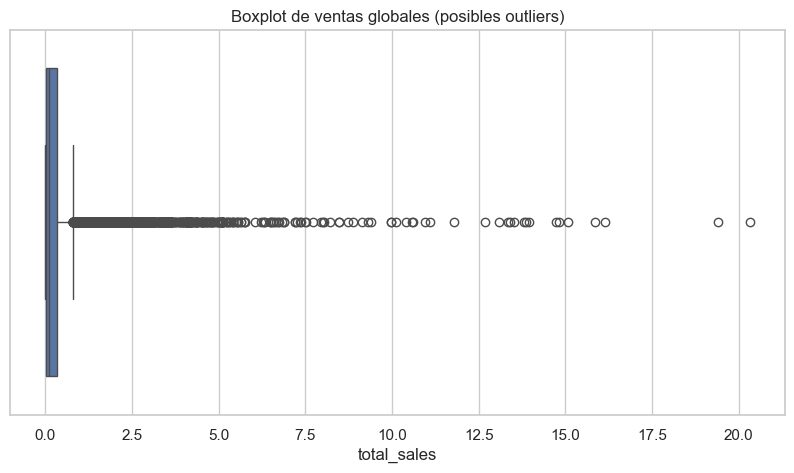

In [4]:
# Dimensiones, columnas y tipos
print("Dimensiones del dataset:", df.shape)
display(df.head())
display(df.dtypes)

# Valores nulos
nulos_abs = df.isna().sum()
nulos_pct = (df.isna().sum() / len(df)) * 100

print("\nValores nulos absolutos:\n")
display(nulos_abs)

print("\nValores nulos en porcentaje:\n")
display(nulos_pct)

# Duplicados
duplicados = df.duplicated().sum()
print("\nNúmero de filas duplicadas:", duplicados)

# Estadísticos descriptivos
print("\nDescripción estadística de variables numéricas:")
display(df.describe())

# Distribución de variables categóricas principales
print("\nTop 10 géneros más frecuentes:")
display(df["genre"].value_counts().head(10))

print("\nTop 10 consolas más frecuentes:")
display(df["console"].value_counts().head(10))

print("\nTop 10 publishers más presentes:")
display(df["publisher"].value_counts().head(10))

print("\nTop 10 developers más frecuentes:")
display(df["developer"].value_counts().head(10))

# Detectar outliers de ventas globales
plt.figure(figsize=(10,5))
sns.boxplot(x=df["total_sales"])
plt.title("Boxplot de ventas globales (posibles outliers)")
plt.show()


In [ ]:
## 1.3 Limpieza del dataset

Una vez evaluada la calidad del dataset, se procede a su limpieza. El objetivo es corregir problemas detectados durante la exploración, estandarizar formatos, eliminar duplicados y preparar los datos para análisis posteriores.

A continuación se explican y justifican cada una de las operaciones realizadas.


### **1. Conversión de tipos de datos**

Durante la exploración se observó que:
- `release_date` y `last_update` se encuentran como texto.
- `critic_score` presenta valores numéricos almacenados como texto en algunos casos.

Para permitir análisis correctos, estas columnas deben convertirse a tipos adecuados:
- **Fechas → datetime**
- **Puntuaciones → numéricas**

La conversión usa `errors="coerce"` para transformar valores inválidos en `NaT` o `NaN`, manteniendo la integridad del dataset.



### **2. Tratamiento de valores nulos**

Tras la exploración:
- `developer` y `publisher` tienen muchos nulos.
- `critic_score` presenta porcentajes altos de valores faltantes.
- Algunas fechas están vacías o mal formateadas.

Decisiones tomadas:
- Para variables categóricas (`developer`, `publisher`), se asigna `"Unknown"` porque:
  - No afectan operaciones numéricas.
  - Evitan perder filas importantes.
- Para `critic_score`, se utiliza la mediana, ya que:
  - Su distribución es sesgada.
  - Mantiene estabilidad frente a outliers.
- Para fechas inválidas, simplemente se almacenan como `NaT`, ya que no son esenciales para el análisis básico.


### **3. Eliminación de duplicados**

En la exploración se detectaron registros duplicados.  
Mantener duplicados puede distorsionar estadísticas, ventas totales o frecuencias.

Se eliminan todos los duplicados usando `drop_duplicates()`.

### **4. Normalización de texto y categorías**

Se han encontrado variables con inconsistencias en formato:
- `genre`: variaciones de mayúsculas/minúsculas.
- `publisher` y `developer`: espacios en blanco y capitalización irregular.
- `console`: formato mayormente consistente, pero se estandariza a mayúsculas para asegurar uniformidad.

Normalizar estas variables permite:
- Evitar duplicados conceptuales (ej. "Action" vs "action").
- Facilitar agrupamientos.
- Mejorar claridad del análisis.

Transformaciones aplicadas:
- `lower()` para géneros.
- `strip()` para eliminar espacios.
- Capitalización estandarizada (`title()`) para publisher/developer.
- Consolas en mayúsculas (`upper()`).


### **5. Eliminación de incoherencias**

Se valida que los valores tengan sentido dentro del dominio del dataset:
- Las ventas totales no pueden ser negativas.
- Las puntuaciones críticas no pueden ser menores que 0.
- Las fechas deben ser realistas (los valores inválidos quedan como `NaT`).

Se eliminan filas con valores imposibles, manteniendo la coherencia interna.

---

### **6. Resultado de la limpieza**

Tras aplicar todas las transformaciones:
- El dataset queda sin duplicados.
- Las fechas se encuentran en formato correcto (`datetime`).
- Las variables categóricas están estandarizadas.
- Las puntuaciones críticas están completas (sin nulos).
- No existen ventas negativas.
- El dataset es más uniforme y fiable para análisis posteriores.

A continuación se muestra el código utilizado.


In [7]:

# 1. Conversión de tipos
print(df["total_sales"].apply(type).value_counts())


df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["last_update"] = pd.to_datetime(df["last_update"], errors="coerce")
df["critic_score"] = pd.to_numeric(df["critic_score"], errors="coerce")


# 2. Tratamiento de valores nulos

df["developer"] = df["developer"].fillna("Unknown")
df["publisher"] = df["publisher"].fillna("Unknown")

# mediana
df["critic_score"] = df["critic_score"].fillna(df["critic_score"].median())


# 3. Eliminación de duplicados

antes = len(df)
df = df.drop_duplicates()
despues = len(df)

print("Duplicados eliminados:", antes - despues)


# 4. Normalización de categorías

df["genre"] = df["genre"].str.strip().str.lower()
df["console"] = df["console"].str.strip().str.upper()
df["publisher"] = df["publisher"].str.strip().str.title()
df["developer"] = df["developer"].str.strip().str.title()


# 5. Eliminación de incoherencias

# Ventas negativas - imposible
df = df[df["total_sales"] >= 0]

# Puntuaciones negativas - imposible
df = df[df["critic_score"] >= 0]


# Comprobación final de calidad

print("\nResumen final de nulos:")
display(df.isna().sum())

print("\nTipos de datos después de la limpieza:")
display(df.dtypes)

print("\nPreview de datos limpios:")
df.head()


total_sales
<class 'float'>    18922
Name: count, dtype: int64
Duplicados eliminados: 0

Resumen final de nulos:


img                 0
title               0
console             0
genre               0
publisher           0
developer           0
critic_score        0
total_sales         0
na_sales         6285
jp_sales        12196
pal_sales        6098
other_sales      3794
release_date       90
last_update     14903
dtype: int64


Tipos de datos después de la limpieza:


img                     object
title                   object
console                 object
genre                   object
publisher               object
developer               object
critic_score           float64
total_sales            float64
na_sales               float64
jp_sales               float64
pal_sales              float64
other_sales            float64
release_date    datetime64[ns]
last_update     datetime64[ns]
dtype: object


Preview de datos limpios:


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaT
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaT
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,action,Rockstar Games,Rockstar North,7.5,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaT
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14
